In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Quantum_Kernel import *

%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit , transpile, Aer ,IBMQ
from qiskit.visualization import *
from qiskit.tools.jupyter import *
from qiskit.providers.ibmq import least_busy
from qiskit.providers.aer import QasmSimulator

from qiskit import Aer, QuantumCircuit
from qiskit.opflow import Z, I, StateFn
from qiskit.utils import QuantumInstance
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.algorithms.optimizers import *

from qiskit.opflow import StateFn, PauliSumOp, AerPauliExpectation, ListOp, Gradient
from qiskit_machine_learning.neural_networks import OpflowQNN
import qiskit.quantum_info as qi
from scipy import optimize
from qiskit.opflow.gradients import Gradient
from typing import Union

from IPython.display import clear_output
from scipy.optimize import approx_fprime


# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

In [6]:
n_samples = 200
outliers_fraction = 0.15
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers
blobs_params = dict(random_state=0, n_samples=n_inliers, n_features=2)

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_circles,make_blobs,make_moons

np.random.seed(0)


data0_X,data0_y = make_circles(n_samples=n_samples, factor=.5, noise=.05)
data0_X = data0_X*5
data1_X,data1_y = make_blobs(centers=[[0, 0], [0, 0]], cluster_std=0.5, **blobs_params)
data2_X,data2_y = make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[0.5, 0.5], **blobs_params)
data3_X,data3_y = make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[1.5, 0.3], **blobs_params)
data4_X,data4_y = make_moons(n_samples=n_samples, noise=0.05, random_state=0)
data4_X = 4.0*(data4_X- np.array([0.5, 0.25]))

datasets_X = [data0_X,data1_X,data2_X,data3_X,data4_X]
datasets_y = [data0_y,data1_y,data2_y,data3_y,data4_y]

rng = np.random.RandomState(42)
for i in range(5) :
    datasets_X[i] = np.concatenate([datasets_X[i], rng.uniform(low=-6, high=6, size=(n_outliers, 2))], axis=0)
    datasets_y[i] = np.concatenate([datasets_y[i],-1*np.ones(n_outliers)])

In [7]:
gaussian_datasets =[]
quantum_datasets =[]
datasets_y_sto = []

for i in range(5) :
    sample = 5

    sto_ind = np.random.randint(0,len(datasets_X[i]),sample)
    data_sto = pd.DataFrame(datasets_X[i]).iloc[sto_ind,:]
    data_sto_y =pd.DataFrame(datasets_y[i]).iloc[sto_ind,:]
    n = len(data_sto)

    start_time = time.time()
    gram_matrix = get_gram(data_sto,kernel_A,shots=1000)
    print("--- %s seconds ---" % (time.time() - start_time))
    
    Gram = Gram_gaussian(data_sto.values,3)
    gaussian_kpca_result = KPCA(Gram)
    gaussian_datasets += [np.array(pd.DataFrame(gaussian_kpca_result[0]).values.tolist())]
    
    quantum_kpca_result = KPCA(gram_matrix)
    quantum_datasets += [np.array(pd.DataFrame(quantum_kpca_result[0]).values.tolist())]
    
    datasets_y_sto += [np.array(data_sto_y)]

  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(15,15))
for i in range(3):
    reds = datasets_y[i] == 0
    blues = datasets_y[i] == 1
    blacks = datasets_y[i] == -1
    reds_sto = (datasets_y_sto[i] == 0).reshape(100)
    blues_sto = (datasets_y_sto[i] == 1).reshape(100)
    blacks_sto = (datasets_y_sto[i] == -1).reshape(100)
    
    plt.subplot(4,3,3*i+1)
    plt.scatter(datasets_X[i][reds,0], datasets_X[i][reds,1], c="red",s=20, edgecolor='k')
    plt.scatter(datasets_X[i][blues,0],datasets_X[i][blues,1], c="blue",s=20, edgecolor='k')
    plt.scatter(datasets_X[i][blacks,0],datasets_X[i][blacks,1], c="black",s=20, edgecolor='k')
    
    plt.subplot(4,3,3*i+2)
    plt.scatter(gaussian_datasets[i][reds_sto.tolist(),0], gaussian_datasets[i][reds_sto.tolist(),1], c="red",s=20, edgecolor='k')
    plt.scatter(gaussian_datasets[i][blues_sto.tolist(),0],gaussian_datasets[i][blues_sto.tolist(),1], c="blue",s=20, edgecolor='k')
    plt.scatter(gaussian_datasets[i][blacks_sto.tolist(),0],gaussian_datasets[i][blacks_sto.tolist(),1], c="black",s=20, edgecolor='k')
    
    plt.subplot(4,3,3*i+3)
    plt.scatter(quantum_datasets[i][reds_sto.tolist(),0],  quantum_datasets[i][reds_sto.tolist(),1], c="red",s=20, edgecolor='k')
    plt.scatter(quantum_datasets[i][blues_sto.tolist(),0], quantum_datasets[i][blues_sto.tolist(),1], c="blue",s=20, edgecolor='k')
    plt.scatter(quantum_datasets[i][blacks_sto.tolist(),0],quantum_datasets[i][blacks_sto.tolist(),1], c="black",s=20, edgecolor='k')
    

In [8]:
datasets_X_S = []
for i in range(5):
    data_temp = datasets_X[i]
    data_temp_scale = 2*np.pi*(data_temp-np.min(data_temp))/(np.max(data_temp)-np.min(data_temp))
    datasets_X_S += [np.array(data_temp_scale)]

In [9]:
gaussian_datasets =[]
quantum_datasets =[]
datasets_y_sto = []

for i in range(5) :
    sample = 100

    sto_ind = np.random.randint(0,len(datasets_X_S[i]),sample)
    data_sto = pd.DataFrame(datasets_X_S[i]).iloc[sto_ind,:]
    data_sto_y =pd.DataFrame(datasets_y[i]).iloc[sto_ind,:]
    n = len(data_sto)

    start_time = time.time()
    gram_matrix = get_gram(data_sto,kernel_A,shots=1000)
    print("--- %s seconds ---" % (time.time() - start_time))
    
    Gram = Gram_gaussian(data_sto.values,3)
    gaussian_kpca_result = KPCA(Gram)
    gaussian_datasets += [np.array(pd.DataFrame(gaussian_kpca_result[0]).values.tolist())]
    
    quantum_kpca_result = KPCA(gram_matrix)
    quantum_datasets += [np.array(pd.DataFrame(quantum_kpca_result[0]).values.tolist())]
    
    datasets_y_sto += [np.array(data_sto_y)]

  0%|          | 0/100 [00:00<?, ?it/s]

--- 8158.308479547501 seconds ---


  0%|          | 0/100 [00:00<?, ?it/s]

--- 8212.326572179794 seconds ---


  0%|          | 0/100 [00:00<?, ?it/s]

--- 6042.613751411438 seconds ---


  0%|          | 0/100 [00:00<?, ?it/s]

--- 5958.36190867424 seconds ---


  0%|          | 0/100 [00:00<?, ?it/s]

--- 5644.877416849136 seconds ---


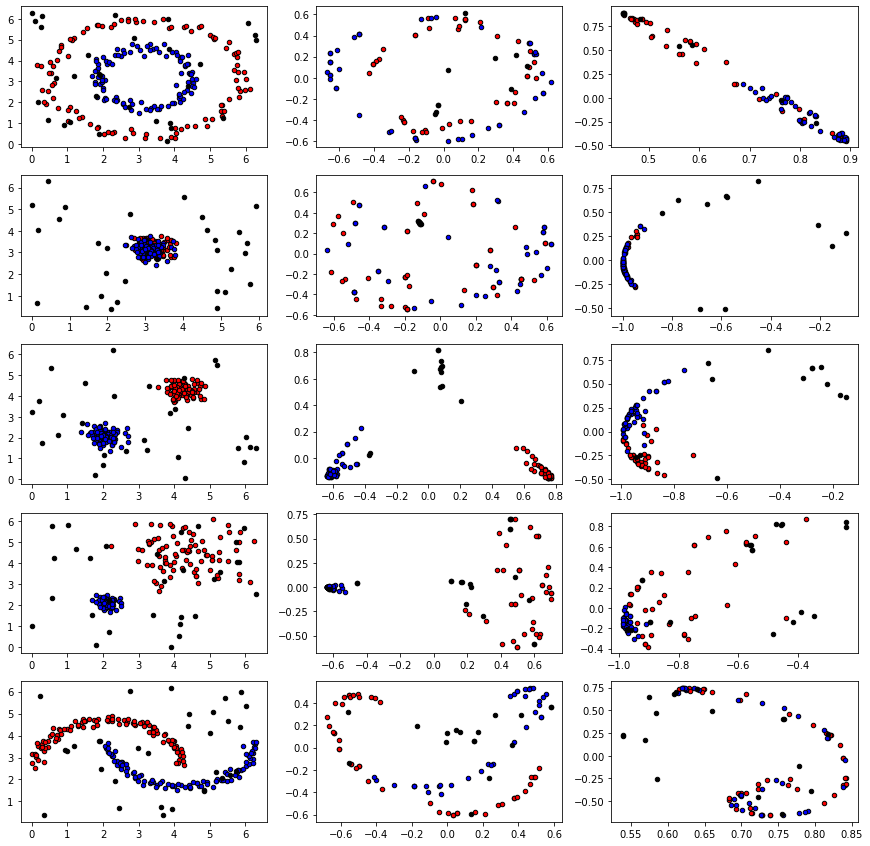

In [10]:
plt.figure(figsize=(15,15))
for i in range(5):
    reds = datasets_y[i] == 0
    blues = datasets_y[i] == 1
    blacks = datasets_y[i] == -1
    reds_sto = (datasets_y_sto[i] == 0).reshape(sample)
    blues_sto = (datasets_y_sto[i] == 1).reshape(sample)
    blacks_sto = (datasets_y_sto[i] == -1).reshape(sample)
    
    plt.subplot(5,3,3*i+1)
    plt.scatter(datasets_X_S[i][reds,0], datasets_X_S[i][reds,1], c="red",s=20, edgecolor='k')
    plt.scatter(datasets_X_S[i][blues,0],datasets_X_S[i][blues,1], c="blue",s=20, edgecolor='k')
    plt.scatter(datasets_X_S[i][blacks,0],datasets_X_S[i][blacks,1], c="black",s=20, edgecolor='k')
    
    plt.subplot(5,3,3*i+2)
    plt.scatter(gaussian_datasets[i][reds_sto.tolist(),0], gaussian_datasets[i][reds_sto.tolist(),1], c="red",s=20, edgecolor='k')
    plt.scatter(gaussian_datasets[i][blues_sto.tolist(),0],gaussian_datasets[i][blues_sto.tolist(),1], c="blue",s=20, edgecolor='k')
    plt.scatter(gaussian_datasets[i][blacks_sto.tolist(),0],gaussian_datasets[i][blacks_sto.tolist(),1], c="black",s=20, edgecolor='k')
    
    plt.subplot(5,3,3*i+3)
    plt.scatter(quantum_datasets[i][reds_sto.tolist(),0],  quantum_datasets[i][reds_sto.tolist(),1], c="red",s=20, edgecolor='k')
    plt.scatter(quantum_datasets[i][blues_sto.tolist(),0], quantum_datasets[i][blues_sto.tolist(),1], c="blue",s=20, edgecolor='k')
    plt.scatter(quantum_datasets[i][blacks_sto.tolist(),0],quantum_datasets[i][blacks_sto.tolist(),1], c="black",s=20, edgecolor='k')
    

In [11]:
gaussian_datasets =[]
quantum_datasets =[]
datasets_y_sto = []

for i in range(5) :
    sample = 5

    sto_ind = np.random.randint(0,len(datasets_X_S[i]),sample)
    data_sto = pd.DataFrame(datasets_X_S[i]).iloc[sto_ind,:]
    data_sto_y =pd.DataFrame(datasets_y[i]).iloc[sto_ind,:]
    n = len(data_sto)

    start_time = time.time()
    gram_matrix = get_gram(data_sto,kernel_E,shots=1000)
    print("--- %s seconds ---" % (time.time() - start_time))
    
    Gram = Gram_gaussian(data_sto.values,3)
    gaussian_kpca_result = KPCA(Gram)
    gaussian_datasets += [np.array(pd.DataFrame(gaussian_kpca_result[0]).values.tolist())]
    
    quantum_kpca_result = KPCA(gram_matrix)
    quantum_datasets += [np.array(pd.DataFrame(quantum_kpca_result[0]).values.tolist())]
    
    datasets_y_sto += [np.array(data_sto_y)]

  0%|          | 0/100 [00:00<?, ?it/s]

--- 15.55950117111206 seconds ---


  0%|          | 0/100 [00:00<?, ?it/s]

--- 16.13760495185852 seconds ---


  0%|          | 0/100 [00:00<?, ?it/s]

--- 19.978941440582275 seconds ---


  0%|          | 0/100 [00:00<?, ?it/s]

--- 23.77816915512085 seconds ---


  0%|          | 0/100 [00:00<?, ?it/s]

--- 28.774592399597168 seconds ---


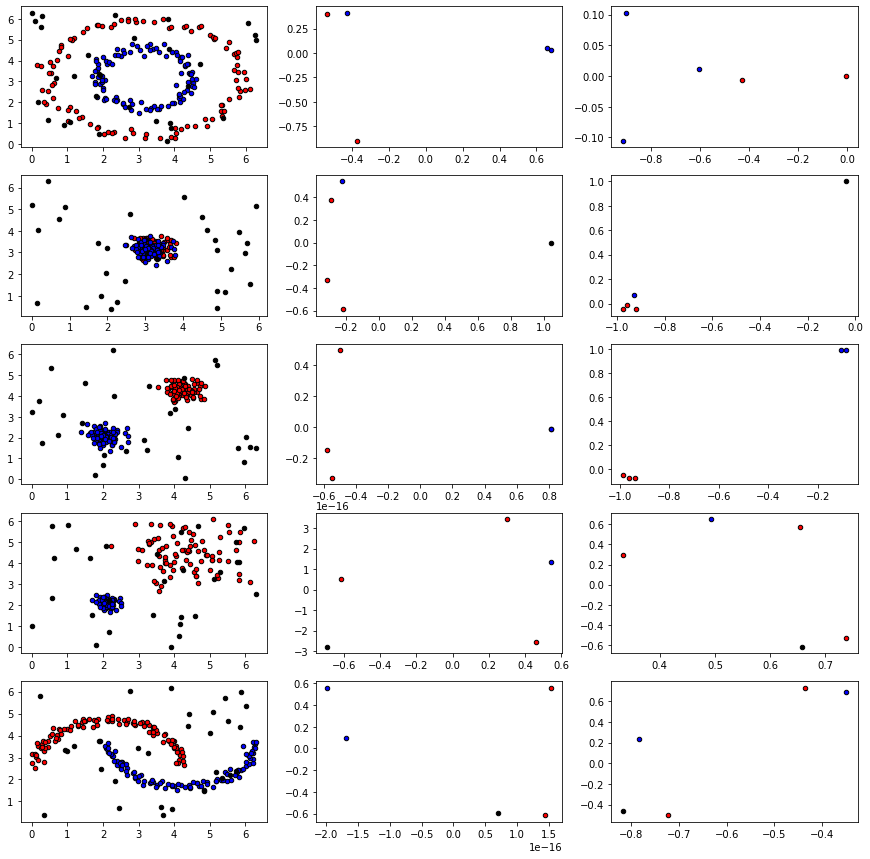

In [12]:
plt.figure(figsize=(15,15))
for i in range(5):
    reds = datasets_y[i] == 0
    blues = datasets_y[i] == 1
    blacks = datasets_y[i] == -1
    reds_sto = (datasets_y_sto[i] == 0).reshape(sample)
    blues_sto = (datasets_y_sto[i] == 1).reshape(sample)
    blacks_sto = (datasets_y_sto[i] == -1).reshape(sample)
    
    plt.subplot(5,3,3*i+1)
    plt.scatter(datasets_X_S[i][reds,0], datasets_X_S[i][reds,1], c="red",s=20, edgecolor='k')
    plt.scatter(datasets_X_S[i][blues,0],datasets_X_S[i][blues,1], c="blue",s=20, edgecolor='k')
    plt.scatter(datasets_X_S[i][blacks,0],datasets_X_S[i][blacks,1], c="black",s=20, edgecolor='k')
    
    plt.subplot(5,3,3*i+2)
    plt.scatter(gaussian_datasets[i][reds_sto.tolist(),0], gaussian_datasets[i][reds_sto.tolist(),1], c="red",s=20, edgecolor='k')
    plt.scatter(gaussian_datasets[i][blues_sto.tolist(),0],gaussian_datasets[i][blues_sto.tolist(),1], c="blue",s=20, edgecolor='k')
    plt.scatter(gaussian_datasets[i][blacks_sto.tolist(),0],gaussian_datasets[i][blacks_sto.tolist(),1], c="black",s=20, edgecolor='k')
    
    plt.subplot(5,3,3*i+3)
    plt.scatter(quantum_datasets[i][reds_sto.tolist(),0],  quantum_datasets[i][reds_sto.tolist(),1], c="red",s=20, edgecolor='k')
    plt.scatter(quantum_datasets[i][blues_sto.tolist(),0], quantum_datasets[i][blues_sto.tolist(),1], c="blue",s=20, edgecolor='k')
    plt.scatter(quantum_datasets[i][blacks_sto.tolist(),0],quantum_datasets[i][blacks_sto.tolist(),1], c="black",s=20, edgecolor='k')
    

In [19]:
gaussian_datasets =[]
quantum_datasets =[]
datasets_y_sto = []

for i in range(5) :
    sample = 30

    sto_ind = np.random.randint(0,len(datasets_X_S[i]),sample)
    data_sto = pd.DataFrame(datasets_X_S[i]).iloc[sto_ind,:]
    data_sto_y =pd.DataFrame(datasets_y[i]).iloc[sto_ind,:]
    n = len(data_sto)

    start_time = time.time()
    gram_matrix = get_gram(data_sto,kernel_E,layer=2,shots=1000)
    print("--- %s seconds ---" % (time.time() - start_time))
    
    Gram = Gram_gaussian(data_sto.values,3)
    gaussian_kpca_result = KPCA(Gram)
    gaussian_datasets += [np.array(pd.DataFrame(gaussian_kpca_result[0]).values.tolist())]
    
    quantum_kpca_result = KPCA(gram_matrix)
    quantum_datasets += [np.array(pd.DataFrame(quantum_kpca_result[0]).values.tolist())]
    
    datasets_y_sto += [np.array(data_sto_y)]

  0%|          | 0/100 [00:00<?, ?it/s]

--- 1105.010279417038 seconds ---


  0%|          | 0/100 [00:00<?, ?it/s]

--- 1106.7268195152283 seconds ---


  0%|          | 0/100 [00:00<?, ?it/s]

--- 1284.8180785179138 seconds ---


  0%|          | 0/100 [00:00<?, ?it/s]

--- 1381.790937423706 seconds ---


  0%|          | 0/100 [00:00<?, ?it/s]

--- 1149.532429933548 seconds ---


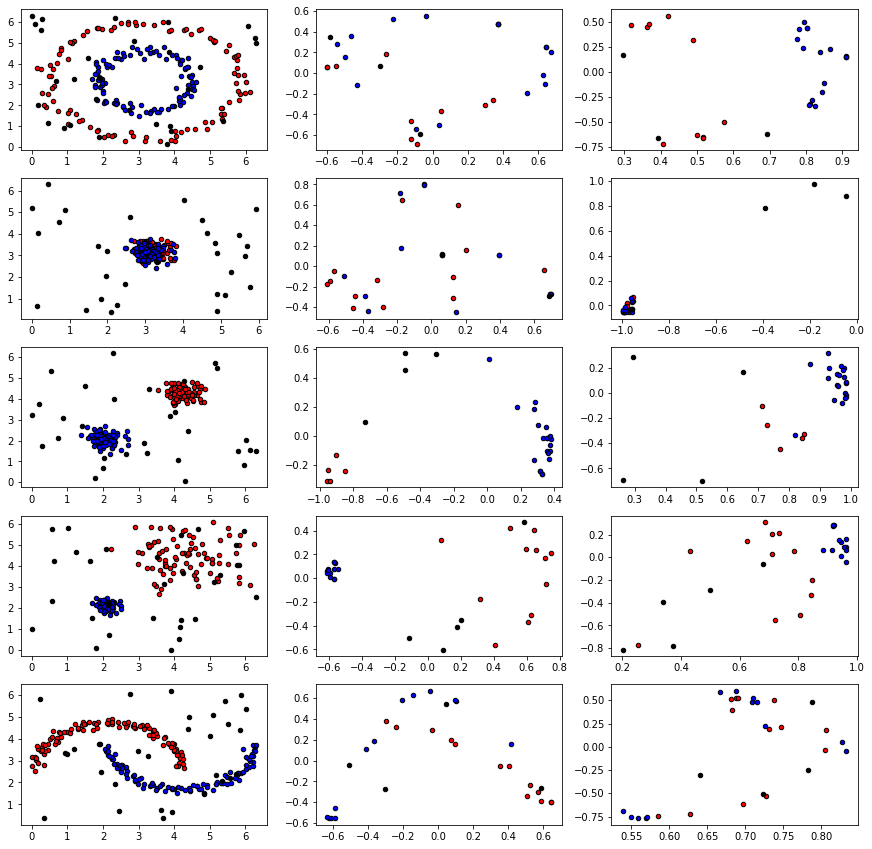

In [20]:
plt.figure(figsize=(15,15))
for i in range(5):
    reds = datasets_y[i] == 0
    blues = datasets_y[i] == 1
    blacks = datasets_y[i] == -1
    reds_sto = (datasets_y_sto[i] == 0).reshape(sample)
    blues_sto = (datasets_y_sto[i] == 1).reshape(sample)
    blacks_sto = (datasets_y_sto[i] == -1).reshape(sample)
    
    plt.subplot(5,3,3*i+1)
    plt.scatter(datasets_X_S[i][reds,0], datasets_X_S[i][reds,1], c="red",s=20, edgecolor='k')
    plt.scatter(datasets_X_S[i][blues,0],datasets_X_S[i][blues,1], c="blue",s=20, edgecolor='k')
    plt.scatter(datasets_X_S[i][blacks,0],datasets_X_S[i][blacks,1], c="black",s=20, edgecolor='k')
    
    plt.subplot(5,3,3*i+2)
    plt.scatter(gaussian_datasets[i][reds_sto.tolist(),0], gaussian_datasets[i][reds_sto.tolist(),1], c="red",s=20, edgecolor='k')
    plt.scatter(gaussian_datasets[i][blues_sto.tolist(),0],gaussian_datasets[i][blues_sto.tolist(),1], c="blue",s=20, edgecolor='k')
    plt.scatter(gaussian_datasets[i][blacks_sto.tolist(),0],gaussian_datasets[i][blacks_sto.tolist(),1], c="black",s=20, edgecolor='k')
    
    plt.subplot(5,3,3*i+3)
    plt.scatter(quantum_datasets[i][reds_sto.tolist(),0],  quantum_datasets[i][reds_sto.tolist(),1], c="red",s=20, edgecolor='k')
    plt.scatter(quantum_datasets[i][blues_sto.tolist(),0], quantum_datasets[i][blues_sto.tolist(),1], c="blue",s=20, edgecolor='k')
    plt.scatter(quantum_datasets[i][blacks_sto.tolist(),0],quantum_datasets[i][blacks_sto.tolist(),1], c="black",s=20, edgecolor='k')
    

In [21]:
gaussian_datasets =[]
quantum_datasets =[]
datasets_y_sto = []

for i in range(5) :
    sample = 30

    sto_ind = np.random.randint(0,len(datasets_X_S[i]),sample)
    data_sto = pd.DataFrame(datasets_X_S[i]).iloc[sto_ind,:]
    data_sto_y =pd.DataFrame(datasets_y[i]).iloc[sto_ind,:]
    n = len(data_sto)

    start_time = time.time()
    gram_matrix = get_gram(data_sto,kernel_E,layer=3,shots=1000)
    print("--- %s seconds ---" % (time.time() - start_time))
    
    Gram = Gram_gaussian(data_sto.values,3)
    gaussian_kpca_result = KPCA(Gram)
    gaussian_datasets += [np.array(pd.DataFrame(gaussian_kpca_result[0]).values.tolist())]
    
    quantum_kpca_result = KPCA(gram_matrix)
    quantum_datasets += [np.array(pd.DataFrame(quantum_kpca_result[0]).values.tolist())]
    
    datasets_y_sto += [np.array(data_sto_y)]

  0%|          | 0/100 [00:00<?, ?it/s]

--- 1599.3538699150085 seconds ---


  0%|          | 0/100 [00:00<?, ?it/s]

--- 2474.6762058734894 seconds ---


  0%|          | 0/100 [00:00<?, ?it/s]

--- 1653.0944194793701 seconds ---


  0%|          | 0/100 [00:00<?, ?it/s]

--- 1853.5775909423828 seconds ---


  0%|          | 0/100 [00:00<?, ?it/s]

--- 1578.3784518241882 seconds ---


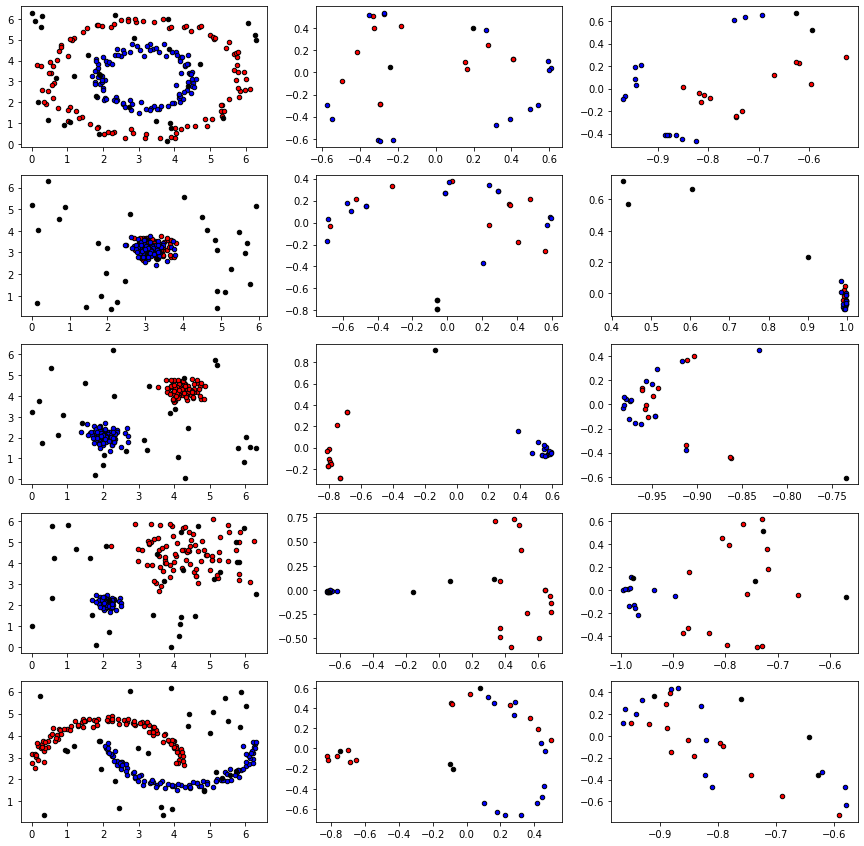

In [22]:
plt.figure(figsize=(15,15))
for i in range(5):
    reds = datasets_y[i] == 0
    blues = datasets_y[i] == 1
    blacks = datasets_y[i] == -1
    reds_sto = (datasets_y_sto[i] == 0).reshape(sample)
    blues_sto = (datasets_y_sto[i] == 1).reshape(sample)
    blacks_sto = (datasets_y_sto[i] == -1).reshape(sample)
    
    plt.subplot(5,3,3*i+1)
    plt.scatter(datasets_X_S[i][reds,0], datasets_X_S[i][reds,1], c="red",s=20, edgecolor='k')
    plt.scatter(datasets_X_S[i][blues,0],datasets_X_S[i][blues,1], c="blue",s=20, edgecolor='k')
    plt.scatter(datasets_X_S[i][blacks,0],datasets_X_S[i][blacks,1], c="black",s=20, edgecolor='k')
    
    plt.subplot(5,3,3*i+2)
    plt.scatter(gaussian_datasets[i][reds_sto.tolist(),0], gaussian_datasets[i][reds_sto.tolist(),1], c="red",s=20, edgecolor='k')
    plt.scatter(gaussian_datasets[i][blues_sto.tolist(),0],gaussian_datasets[i][blues_sto.tolist(),1], c="blue",s=20, edgecolor='k')
    plt.scatter(gaussian_datasets[i][blacks_sto.tolist(),0],gaussian_datasets[i][blacks_sto.tolist(),1], c="black",s=20, edgecolor='k')
    
    plt.subplot(5,3,3*i+3)
    plt.scatter(quantum_datasets[i][reds_sto.tolist(),0],  quantum_datasets[i][reds_sto.tolist(),1], c="red",s=20, edgecolor='k')
    plt.scatter(quantum_datasets[i][blues_sto.tolist(),0], quantum_datasets[i][blues_sto.tolist(),1], c="blue",s=20, edgecolor='k')
    plt.scatter(quantum_datasets[i][blacks_sto.tolist(),0],quantum_datasets[i][blacks_sto.tolist(),1], c="black",s=20, edgecolor='k')
    

In [23]:
datasets_X_S = []
for i in range(5):
    data_temp = datasets_X[i]
    data_temp_scale = np.pi*(data_temp-np.min(data_temp))/(np.max(data_temp)-np.min(data_temp))
    datasets_X_S += [np.array(data_temp_scale)]

In [24]:
gaussian_datasets =[]
quantum_datasets =[]
datasets_y_sto = []

for i in range(5) :
    sample = 30

    sto_ind = np.random.randint(0,len(datasets_X_S[i]),sample)
    data_sto = pd.DataFrame(datasets_X_S[i]).iloc[sto_ind,:]
    data_sto_y =pd.DataFrame(datasets_y[i]).iloc[sto_ind,:]
    n = len(data_sto)

    start_time = time.time()
    gram_matrix = get_gram(data_sto,kernel_E,layer=3,shots=1000)
    print("--- %s seconds ---" % (time.time() - start_time))
    
    Gram = Gram_gaussian(data_sto.values,3)
    gaussian_kpca_result = KPCA(Gram)
    gaussian_datasets += [np.array(pd.DataFrame(gaussian_kpca_result[0]).values.tolist())]
    
    quantum_kpca_result = KPCA(gram_matrix)
    quantum_datasets += [np.array(pd.DataFrame(quantum_kpca_result[0]).values.tolist())]
    
    datasets_y_sto += [np.array(data_sto_y)]

  0%|          | 0/100 [00:00<?, ?it/s]

--- 3177.7464718818665 seconds ---


  0%|          | 0/100 [00:00<?, ?it/s]

--- 3437.337141752243 seconds ---


  0%|          | 0/100 [00:00<?, ?it/s]

--- 2707.8716781139374 seconds ---


  0%|          | 0/100 [00:00<?, ?it/s]

--- 2128.3623456954956 seconds ---


  0%|          | 0/100 [00:00<?, ?it/s]

--- 1481.6046772003174 seconds ---


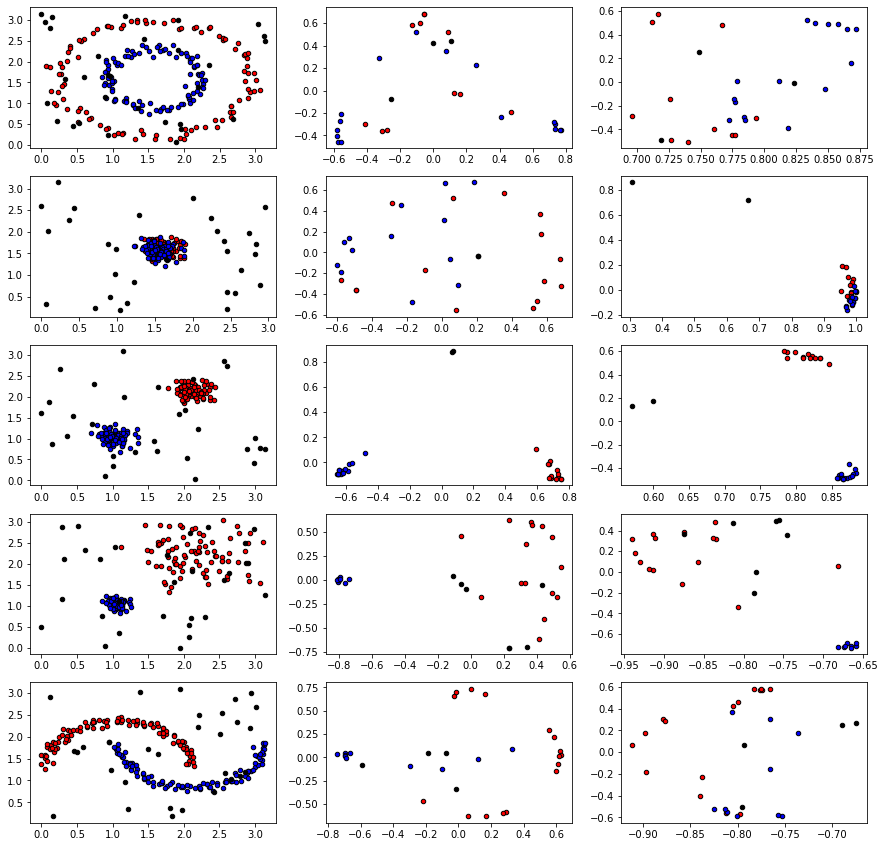

In [25]:
plt.figure(figsize=(15,15))
for i in range(5):
    reds = datasets_y[i] == 0
    blues = datasets_y[i] == 1
    blacks = datasets_y[i] == -1
    reds_sto = (datasets_y_sto[i] == 0).reshape(sample)
    blues_sto = (datasets_y_sto[i] == 1).reshape(sample)
    blacks_sto = (datasets_y_sto[i] == -1).reshape(sample)
    
    plt.subplot(5,3,3*i+1)
    plt.scatter(datasets_X_S[i][reds,0], datasets_X_S[i][reds,1], c="red",s=20, edgecolor='k')
    plt.scatter(datasets_X_S[i][blues,0],datasets_X_S[i][blues,1], c="blue",s=20, edgecolor='k')
    plt.scatter(datasets_X_S[i][blacks,0],datasets_X_S[i][blacks,1], c="black",s=20, edgecolor='k')
    
    plt.subplot(5,3,3*i+2)
    plt.scatter(gaussian_datasets[i][reds_sto.tolist(),0], gaussian_datasets[i][reds_sto.tolist(),1], c="red",s=20, edgecolor='k')
    plt.scatter(gaussian_datasets[i][blues_sto.tolist(),0],gaussian_datasets[i][blues_sto.tolist(),1], c="blue",s=20, edgecolor='k')
    plt.scatter(gaussian_datasets[i][blacks_sto.tolist(),0],gaussian_datasets[i][blacks_sto.tolist(),1], c="black",s=20, edgecolor='k')
    
    plt.subplot(5,3,3*i+3)
    plt.scatter(quantum_datasets[i][reds_sto.tolist(),0],  quantum_datasets[i][reds_sto.tolist(),1], c="red",s=20, edgecolor='k')
    plt.scatter(quantum_datasets[i][blues_sto.tolist(),0], quantum_datasets[i][blues_sto.tolist(),1], c="blue",s=20, edgecolor='k')
    plt.scatter(quantum_datasets[i][blacks_sto.tolist(),0],quantum_datasets[i][blacks_sto.tolist(),1], c="black",s=20, edgecolor='k')
    

In [29]:
for i in range(5):
    pd.DataFrame(quantum_datasets[i]).to_csv("simulation_gaussian"+str(i)+".csv")
for i in range(5):
    pd.DataFrame(quantum_datasets[i]).to_csv("simulation_quantum"+str(i)+".csv")
for i in range(5):
    pd.DataFrame(datasets_y_sto[i]).to_csv("simulation_y_sto"+str(i)+".csv")
for i in range(5):
    pd.DataFrame(datasets_X_S[i]).to_csv("simulation_original"+str(i)+".csv")
